In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os  
import glob
from collections import Counter
from scipy.stats import binned_statistic
from IPython.display import clear_output
from collections import OrderedDict
import networkx as nx
import math
from scipy import stats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import csv

# Aumentar espessura da box no plot
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.4 #set the value globally
#from collections import Counter

In [253]:
# Create network and calculate assortativity dataframe
connections = pd.read_csv("edgeList.csv")    # read edgeList

number_of_edges = len(connections["source"].values) # number of edges
source_nodes_list = connections["source"].values # source nodes in tuples
target_nodes_list = connections["target"].values # target nodes in tuples

con_ = [(source_nodes_list[i],target_nodes_list[i]) for i in range(number_of_edges)] # Create tuples in list (source,target) for all links in network
G=nx.from_edgelist(con_) # Create graph in networkx from tuples

#G.number_of_nodes return number of nodes in network and G.degree[i]=degree of node i.
degree = [G.degree[i] for i in range(G.number_of_nodes())] # Create list with degree nodes
k_ij = [] 
for i in range(G.number_of_nodes()):  # run for all nodes
    degreekij = [degree[j] for j in [n for n in G.neighbors(i)]] # select degree for all neighbors node i
    Ter = sum(degreekij)/degree[i] # Sum(degree all neighbors) / degree[node]
    k_ij.append(Ter)               # add to k_ij list

data_assortativity = pd.DataFrame(data={"k":degree,"knn":k_ij}) # create dataframe with rows k, knn
data_final = data_assortativity.groupby("k").mean().reset_index() # group dataframe from k

# Calculate the degree assortativity coefficient
r = nx.degree_assortativity_coefficient(G) 

-0.12255282002391331


In [227]:
# Replace node_id to name from nodesList
node_labels_data = pd.read_csv("nodeList.csv") # load nodeList.csv
node_labels = node_labels_data.iloc[:, [0,2]]  # select just colums 0 and 2

new_source_list = [] # new source list with name in node_label
new_target_list = [] # new target list with name in node_label

for i in range(G.number_of_edges()): # Run for all edges
    w_s = np.where(node_labels["node_id"]==source_nodes_list[i]) # select the line where "node_id"=element in source
    w_t = np.where(node_labels["node_id"]==target_nodes_list[i]) # select the line where "node_id"=element in target
    
    author_s = node_labels["author"][w_s[0][0]]  # selects the corresponding element in the author column (source)
    author_t = node_labels["author"][w_t[0][0]]  # selects the corresponding element in the author column (target)
    
    new_source_list.append(author_s)
    new_target_list.append(author_t)

con__ = [(new_source_list[i],new_target_list[i]) for i in range(number_of_links)] # Create new tuples in list (source,target) for all links in network
G_=nx.from_edgelist(con__) # Create graph in networkx from new tuples
nx.write_gml(G_,"network.gml",stringizer=None) # save network in .gml extension to read in gephi

In [ ]:
def drop_zeros(a_list):
    return [i for i in a_list if i>0]

# log_binning 2D
# x: k
# y: knn
# num_bin: number of bins in binning
def binning_2d(x,y, num_bins):
    x_bin, y_bin = [],[]

    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    min_x = np.log10(min(drop_zeros(x)))

    bins_aux = np.logspace(min_x,max_base,num=num_bins)
    bins = [(bins_aux[q],bins_aux[q+1]) for q in range(len(bins_aux)-1)]

    box_bins_k = [[] for _ in range(len(bins))]
    box_bins_knn = [[] for _ in range(len(bins))]

    for l in range(len(x)):
        for m in range(len(bins)):
            if(bins[m][0]<=x[l]<=bins[m][1]):
                box_bins_k[m].append(x[l])
                box_bins_knn[m].append(y[l])

    index_list = []
    for idk,element in enumerate(box_bins_k):
        if(len(element)!=0):
            index_list.append(idk)

    box_bins_k = [box_bins_k[q] for q in index_list]
    box_bins_knn = [box_bins_knn[q] for q in index_list]

    x_bin = [np.mean(box_bins_k[q]) for q in range(len(box_bins_k))]
    y_bin = [np.mean(box_bins_knn[q]) for q in range(len(box_bins_knn))]
    return x_bin,y_bin

In [ ]:
x = data_final["k"].values
y = data_final["knn"].values
n_box = 50
x_bin,y_bin = binning_2d(x, y,n_box) # k and knn in log_binning

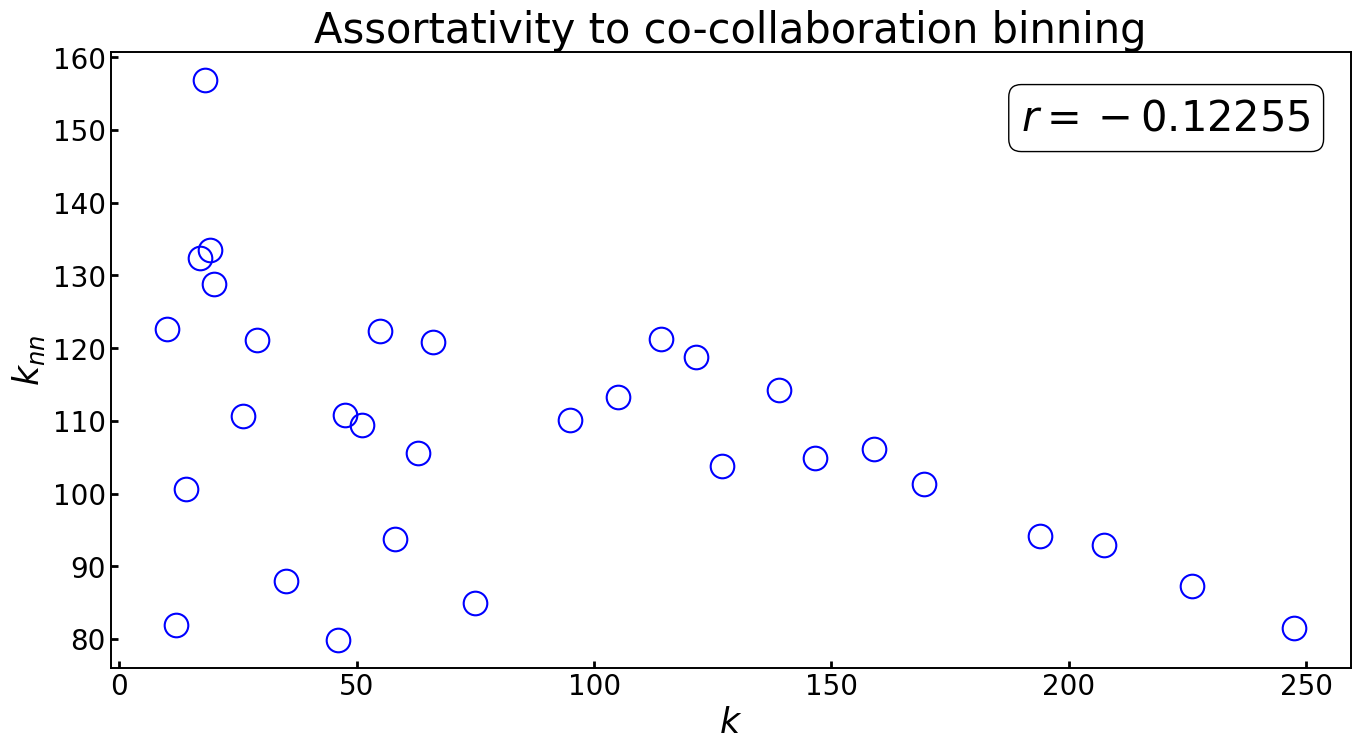

In [286]:
# plot with binning data
plt.figure(figsize=(16,8))
ms = 17
plt.plot(x_bin,y_bin,"o",ms=ms,mfc="None",mec="b",markeredgewidth=1.5)
plt.xlabel(r"$k$",fontsize=25)
plt.ylabel(r"$k_{nn}$",fontsize=25)
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="none")
plt.text(190, 150, f"$r = {r:.5f}$", fontsize=30, color="black", bbox=bbox_props)
plt.title("Assortativity to co-collaboration binning",fontsize=30)
plt.tick_params(axis="both", direction='in',width=2,length=5)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
plt.savefig("imagens/assortativity_binning.pdf",dpi=300)
plt.show()

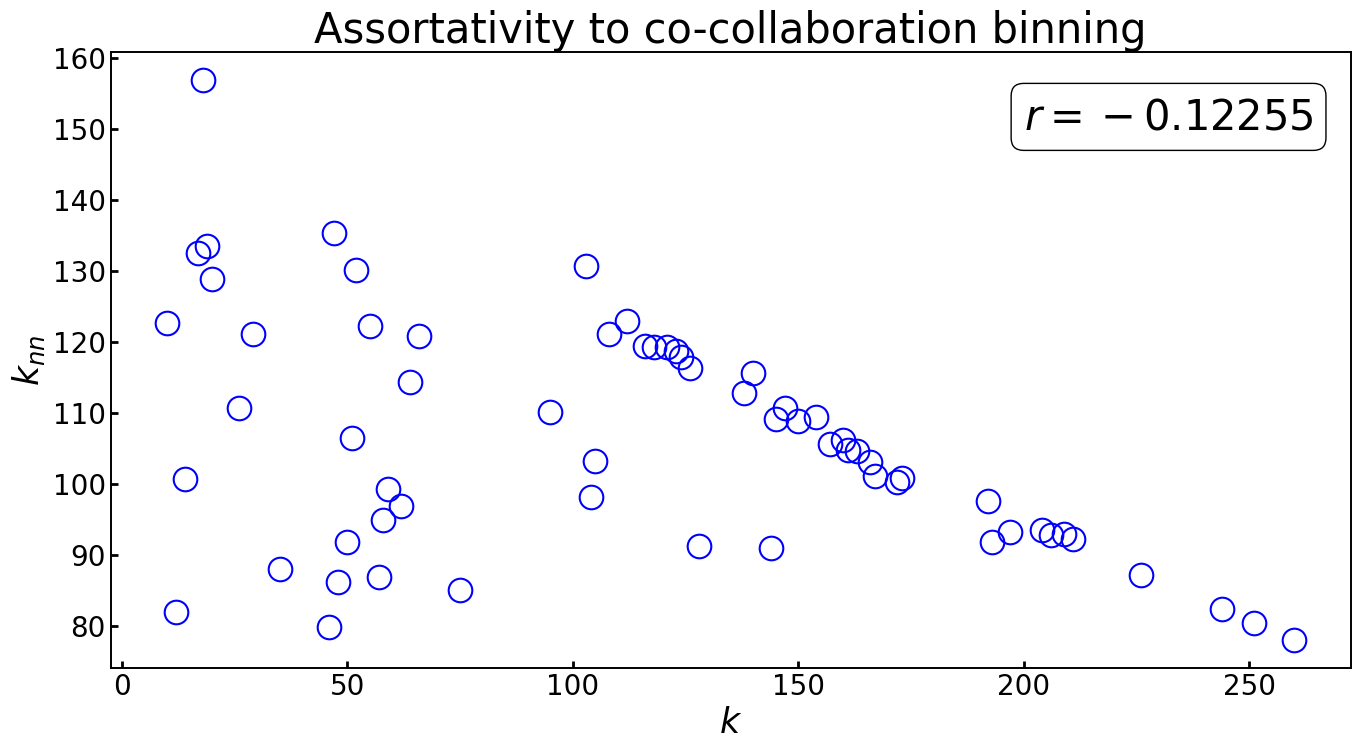

In [287]:
# plot with binning data
plt.figure(figsize=(16,8))
ms = 17
plt.plot(data_final["k"].values,data_final["knn"].values,"o",ms=ms,mfc="None",mec="b",markeredgewidth=1.5)
plt.xlabel(r"$k$",fontsize=25)
plt.ylabel(r"$k_{nn}$",fontsize=25)
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="none")
plt.text(200, 150, f"$r = {r:.5f}$", fontsize=30, color="black", bbox=bbox_props)
plt.title("Assortativity to co-collaboration binning",fontsize=30)
plt.tick_params(axis="both", direction='in',width=2,length=5)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
plt.savefig("/imagens/assortativity_w_binning.pdf",dpi=300)
plt.show()